In [1]:
import sys
import os

# Adding the root folder to sys path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import json
import pandas as pd
from rich.panel import Panel
from rich.console import Console
from src.data_loaders.yf_loader import YFinanceLoader
from src.analysis.benfords_law import BenfordsLawAnalyzer
from src.data_loaders.wiki_sp500_scraper import ScraperFactory, ScraperType

In [9]:
console = Console()

yf_loader = YFinanceLoader()
bf_analyzer = BenfordsLawAnalyzer()
llm_scraper = ScraperFactory.get_scraper(ScraperType.LLM)
pandas_scraper = ScraperFactory.get_scraper(ScraperType.PANDAS)

In [4]:
print(f"llm_scraper.scraper_name: {llm_scraper.scraper_name}")
print(f"pandas_scraper.scraper_name: {pandas_scraper.scraper_name}")

llm_scraper.scraper_name: LLMTableScraper
pandas_scraper.scraper_name: PandasTableScraper


In [5]:
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

In [ ]:
# ! Beware of rate limits of firecrawl

# We will skip this cell since we already know that pandas is more performant in scraping the table on the wiki page

# scraped_df_llm = llm_scraper.scrape_table(url)

# You can run the following for comparison if needed

# if not scraped_df_llm.equals(scraped_df_pandas):
#     differences = scraped_df_llm.compare(scraped_df_pandas)
#     print("Differences:")
#     print(differences) 

In [6]:
scraped_df_pandas = pandas_scraper.scrape_table(url, table_index=0)

# * made updates to the read_html input args to prevent FutureWarning
# * added schema validation to be a private method that get executed after the table is fetched

scraped_df_pandas.head()

2025-08-30 15:52:44.699 | INFO     | src.data_loaders.wiki_sp500_scraper:_validate_and_clean_df:53 - Successfully validated DataFrame with 503 rows against SP500ConstituentSchema


,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [7]:
tickers = scraped_df_pandas["Symbol"].tolist()

# * not super performant to loop through tickers for stock info dict as we are making a lot of api calls

# * added automatic schema validation using pandera once the market cap data is retrieved
df = yf_loader.get_market_cap(tickers, prefer_calc=False)

# * Its almost 3 times slower because we have to get latest closing price * outstandingShares in the stock info to get the latest market cap
df_manual = yf_loader.get_market_cap(tickers, prefer_calc=True)

2025-08-30 15:53:35.760 | INFO     | src.data_loaders.yf_loader:get_market_cap:173 - Market cap data validation successful.
2025-08-30 15:54:53.668 | INFO     | src.data_loaders.yf_loader:get_market_cap:173 - Market cap data validation successful.


In [8]:
# The market cap dataframes will be slightly misaligned due to differences in the calculation methods/data ingestion frequency
pd.concat([df, df_manual], axis=1)

,symbol,marketCap,symbol,marketCap
0,MMM,8.283995e+10,MMM,8.285060e+10
1,AOS,1.003606e+10,AOS,8.145596e+09
2,ABT,2.308894e+11,ABT,2.309416e+11
3,ABBV,3.716842e+11,ABBV,3.719139e+11
4,ACN,1.619231e+11,ACN,1.620228e+11
...,...,...,...,...
498,XYL,3.445712e+10,XYL,3.445225e+10
499,YUM,4.078947e+10,YUM,4.073396e+10
500,ZBRA,1.612250e+10,ZBRA,1.612047e+10
501,ZBH,2.101799e+10,ZBH,2.102393e+10


In [15]:
result = bf_analyzer.analyze(df, field="marketCap")
console.print(result)

2025-08-30 15:57:27.996 | INFO     | src.analysis.benfords_law:_extract_first_digits:92 - Extracted 501 valid first digits from 501 total values


{
    'field_name': 'marketCap',
    'total_values': 501,
    'valid_values': 501,
    'theoretical_distribution': {
        1: np.float64(0.3010299956639812),
        2: np.float64(0.17609125905568124),
        3: np.float64(0.12493873660829993),
        4: np.float64(0.09691001300805642),
        5: np.float64(0.07918124604762482),
        6: np.float64(0.06694678963061322),
        7: np.float64(0.05799194697768673),
        8: np.float64(0.05115252244738129),
        9: np.float64(0.04575749056067514)
    },
    'observed_distribution': {
        1: 0.3253493013972056,
        2: 0.20958083832335328,
        3: 0.12574850299401197,
        4: 0.07784431137724551,
        5: 0.0658682634730539,
        6: 0.05588822355289421,
        7: 0.04590818363273453,
        8: 0.03992015968063872,
        9: 0.05389221556886228
    },
    'chi_square_test': {
        'statistic': np.float64(11.315380985821792),
        'p_value': np.float64(0.18446154098614584),
        'degrees_of_freedom': 8,
        'significant': np.False_,
        'interpretation': "Not significantly different from Benford's Law (p >= 0.05)"
    },
    'ks_test': {
        'statistic': np.float64(0.05861865138660838),
        'critical_value': np.float64(0.06076031901879276),
        'confidence_level': 0.95,
        'significant': np.False_,
        'interpretation': "Not significantly different from Benford's Law at 95% confidence"
    },
    'mean_absolute_deviation': {
        'mad': np.float64(0.014834083643287912),
        'conformity_level': "Marginal Dispersion: Suggests some deviation from Benford's Law, which may be 
acceptable.",
        'interpretation': "MAD = 0.014834 indicates marginal dispersion: suggests some deviation from benford's 
law, which may be acceptable."
    },
    'summary': "The data likely follows Benford's Law. Marginal Dispersion: Suggests some deviation from Benford's 
Law, which may be acceptable. detected."
}

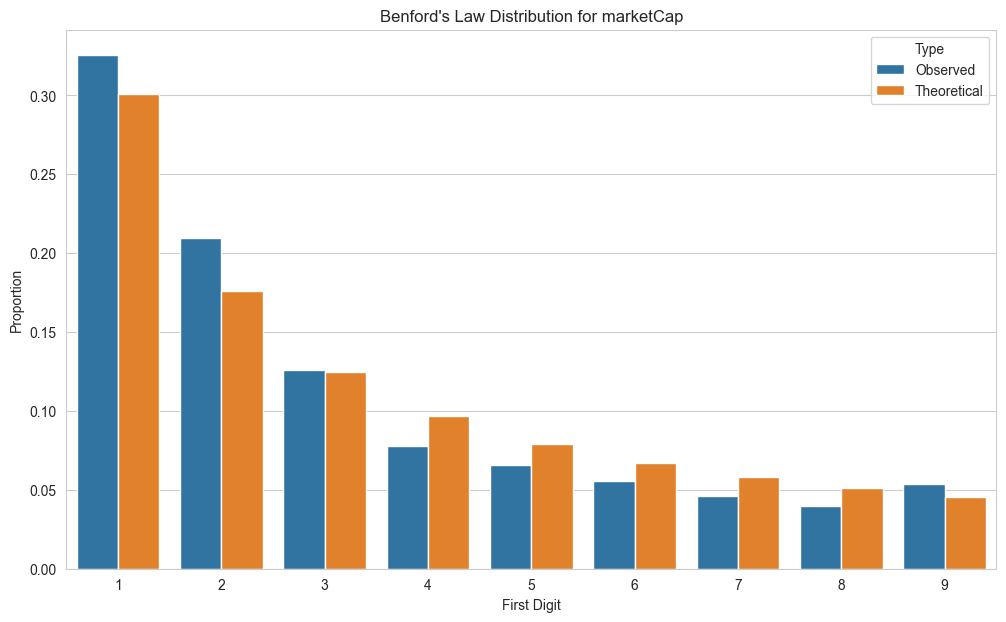

In [16]:
bf_analyzer.plot_distribution(show_plot=True)

In [17]:
result = bf_analyzer.analyze(df_manual, field="marketCap")
console.print(result)

2025-08-30 15:58:13.616 | INFO     | src.analysis.benfords_law:_extract_first_digits:92 - Extracted 501 valid first digits from 501 total values


{
    'field_name': 'marketCap',
    'total_values': 501,
    'valid_values': 501,
    'theoretical_distribution': {
        1: np.float64(0.3010299956639812),
        2: np.float64(0.17609125905568124),
        3: np.float64(0.12493873660829993),
        4: np.float64(0.09691001300805642),
        5: np.float64(0.07918124604762482),
        6: np.float64(0.06694678963061322),
        7: np.float64(0.05799194697768673),
        8: np.float64(0.05115252244738129),
        9: np.float64(0.04575749056067514)
    },
    'observed_distribution': {
        1: 0.32934131736526945,
        2: 0.2055888223552894,
        3: 0.11976047904191617,
        4: 0.07784431137724551,
        5: 0.07984031936127745,
        6: 0.0499001996007984,
        7: 0.03992015968063872,
        8: 0.041916167664670656,
        9: 0.05588822355289421
    },
    'chi_square_test': {
        'statistic': np.float64(12.75434394081722),
        'p_value': np.float64(0.12058603095224425),
        'degrees_of_freedom': 8,
        'significant': np.False_,
        'interpretation': "Not significantly different from Benford's Law (p >= 0.05)"
    },
    'ks_test': {
        'statistic': np.float64(0.05780888500089637),
        'critical_value': np.float64(0.06076031901879276),
        'confidence_level': 0.95,
        'significant': np.False_,
        'interpretation': "Not significantly different from Benford's Law at 95% confidence"
    },
    'mean_absolute_deviation': {
        'mad': np.float64(0.015244153623726251),
        'conformity_level': "High Dispersion: Indicates significant deviation from Benford's Law, suggesting 
potential data anomalies.",
        'interpretation': "MAD = 0.015244 indicates high dispersion: indicates significant deviation from benford's
law, suggesting potential data anomalies."
    },
    'summary': "The data likely follows Benford's Law. High Dispersion: Indicates significant deviation from 
Benford's Law, suggesting potential data anomalies. detected."
}

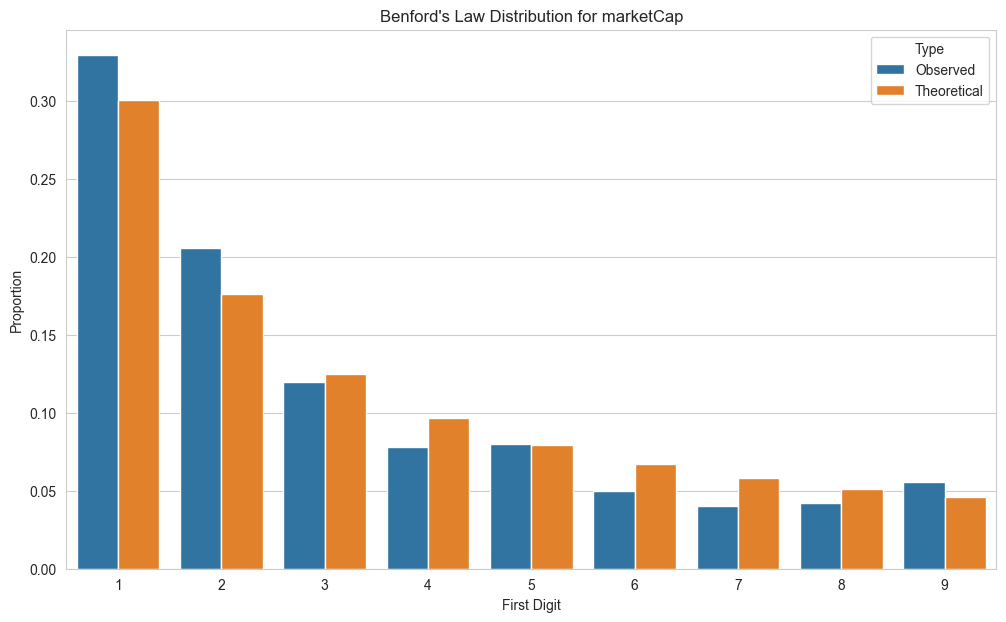

In [ ]:
# Should not be any different even if we use a more rigorous calculation by close * oustanding shares
bf_analyzer.plot_distribution(show_plot=True)

In [ ]:
# Try another financial metric
df_payout = yf_loader.get_stock_info(tickers, ["payoutRatio"])

In [ ]:
# It's not going to follow benford's law distribution closely because it has a clear minimum and maximum
result = bf_analyzer.analyze(df_payout, field="payoutRatio")
console.print(result)

2025-08-30 16:02:17.581 | INFO     | src.analysis.benfords_law:_extract_first_digits:92 - Extracted 63 valid first digits from 503 total values


{
    'field_name': 'payoutRatio',
    'total_values': 503,
    'valid_values': 63,
    'theoretical_distribution': {
        1: np.float64(0.3010299956639812),
        2: np.float64(0.17609125905568124),
        3: np.float64(0.12493873660829993),
        4: np.float64(0.09691001300805642),
        5: np.float64(0.07918124604762482),
        6: np.float64(0.06694678963061322),
        7: np.float64(0.05799194697768673),
        8: np.float64(0.05115252244738129),
        9: np.float64(0.04575749056067514)
    },
    'observed_distribution': {
        1: 0.6349206349206349,
        2: 0.1111111111111111,
        3: 0.06349206349206349,
        4: 0.047619047619047616,
        5: 0.031746031746031744,
        6: 0.06349206349206349,
        7: 0.015873015873015872,
        8: 0.0,
        9: 0.031746031746031744
    },
    'chi_square_test': {
        'statistic': np.float64(35.54692264753747),
        'p_value': np.float64(2.1250876849461422e-05),
        'degrees_of_freedom': 8,
        'significant': np.True_,
        'interpretation': "Significantly different from Benford's Law (p < 0.05)"
    },
    'ks_test': {
        'statistic': np.float64(0.3338906392566537),
        'critical_value': np.float64(0.17134389443084969),
        'confidence_level': 0.95,
        'significant': np.True_,
        'interpretation': "Significantly different from Benford's Law at 95% confidence"
    },
    'mean_absolute_deviation': {
        'mad': np.float64(0.07419791983481193),
        'conformity_level': "High Dispersion: Indicates significant deviation from Benford's Law, suggesting 
potential data anomalies.",
        'interpretation': "MAD = 0.074198 indicates high dispersion: indicates significant deviation from benford's
law, suggesting potential data anomalies."
    },
    'summary': "The data likely does not follow Benford's Law. Multiple tests indicate deviation."
}

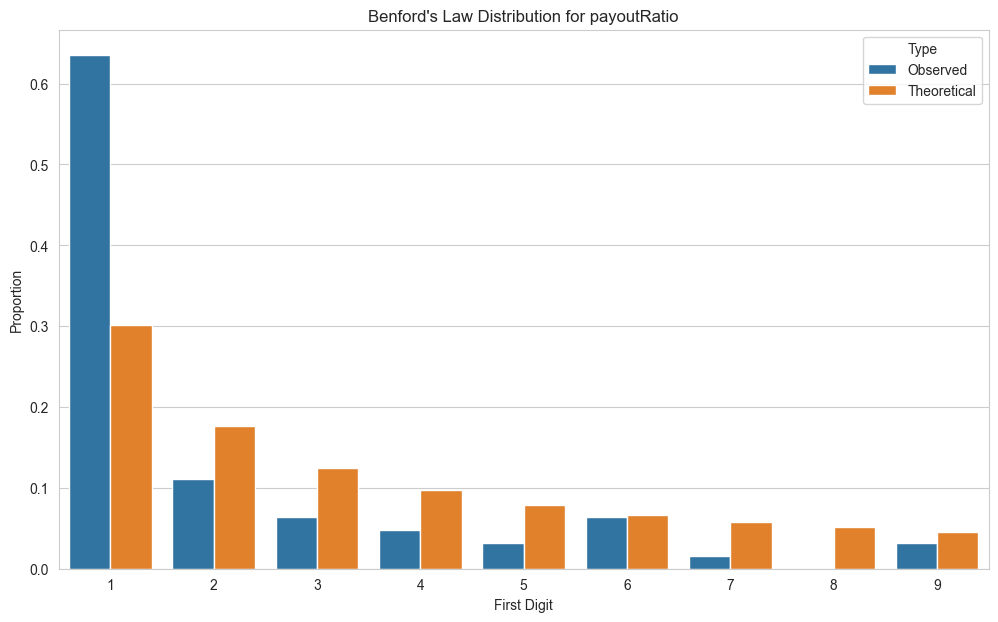

In [23]:
bf_analyzer.plot_distribution(show_plot=True)